In [28]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

# -----------------------------------------------------------------------------
# 설정 (Configuration) - 이전 코드에서 정의된 내용을 사용하거나 다시 정의
# -----------------------------------------------------------------------------
# 스펙트로그램 이미지가 저장된 최종 경로 (Stage 1 모델 학습 시 필요)
OUTPUT_SPECTROGRAM_BASE_DIR = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/spectrograms'
METADATA_STAGE1_CSV = os.path.join('C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset', 'metadata_stage1.csv')
METADATA_STAGE2_CSV = os.path.join('C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset', 'metadata_stage2.csv')

# 헬퍼 함수 정의 (이전과 동일)
def load_dataframes():
    """메타데이터 DataFrame을 로드합니다."""
    try:
        df_stage1 = pd.read_csv(METADATA_STAGE1_CSV)
        df_stage2 = pd.read_csv(METADATA_STAGE2_CSV)
        print("메타데이터 DataFrame 로드 완료.")
        return df_stage1, df_stage2
    except FileNotFoundError:
        print(f"오류: 메타데이터 CSV 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        print("모델 학습을 중단합니다.")
        return None, None

def correct_spectrogram_filepath(row, base_spectrogram_dir):
    original_filepath = row['filepath']
    label = row['label']
    base_name = os.path.splitext(os.path.basename(original_filepath).replace(':', '_').replace(' ', '_'))[0]
    spectrogram_filename = base_name + '.png'
    final_spectrogram_path = os.path.join(base_spectrogram_dir, label, spectrogram_filename)
    return final_spectrogram_path

# -----------------------------------------------------------------------------
# 1단계: 정상(Normal) / 비정상(Abnormal) 이진 분류 모델 학습을 위한 데이터 준비
# -----------------------------------------------------------------------------
print("\n--- 1단계: 데이터 로드 및 분할 시작 ---")

df_stage1, df_stage2 = load_dataframes()

if df_stage1 is None or df_stage2 is None:
    # 이 경우, 파일이 없으므로 이후 과정 진행 불가
    print("메타데이터 로드 실패로 1단계 학습 데이터 준비를 중단합니다.")
else:
    # 1단계 스펙트로그램 이미지의 실제 저장 경로로 filepath 컬럼 업데이트
    df_stage1['filepath'] = df_stage1.apply(
        lambda row: correct_spectrogram_filepath(row, os.path.join(OUTPUT_SPECTROGRAM_BASE_DIR, 'stage1')), axis=1
    )
    # 경로 정규화
    df_stage1['filepath'] = df_stage1['filepath'].apply(os.path.normpath)

    # 데이터 분할: train_df1, val_df1, test_df1 생성
    # 7:1.5:1.5 비율로 분할하기 위해 0.3 (30%)을 테스트로 먼저 나누고,
    # 남은 30%를 다시 0.5 (50%)로 나눠 검증/테스트로 사용합니다.
    train_df1, test_df1_temp = train_test_split(df_stage1, test_size=0.3, random_state=42, stratify=df_stage1['label'])
    val_df1, test_df1 = train_test_split(test_df1_temp, test_size=0.5, random_state=42, stratify=test_df1_temp['label'])

    print(f"1단계 Train 데이터 수: {len(train_df1)}")
    print(f"1단계 Val 데이터 수: {len(val_df1)}")
    print(f"1단계 Test 데이터 수: {len(test_df1)}")
    
    # 이제 train_df1이 정의되었으므로 클래스 가중치를 계산할 수 있습니다.
    # 클래스 가중치 계산 (Stage 1)
    class_weights_stage1 = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df1['label']),
        y=train_df1['label']
    )
    label_to_index_stage1 = {label: index for index, label in enumerate(train_df1['label'].unique())}
    class_weights_dict_stage1 = {label_to_index_stage1[label]: weight for label, weight in zip(np.unique(train_df1['label']), class_weights_stage1)}
    print("1단계 클래스 가중치:", class_weights_dict_stage1)

    print("--- 1단계: 데이터 로드 및 분할 완료 ---")



--- 1단계: 데이터 로드 및 분할 시작 ---
메타데이터 DataFrame 로드 완료.
1단계 Train 데이터 수: 5376
1단계 Val 데이터 수: 1152
1단계 Test 데이터 수: 1152
1단계 클래스 가중치: {1: 0.8687782805429864, 0: 1.177914110429448}
--- 1단계: 데이터 로드 및 분할 완료 ---


In [29]:
# 클래스 가중치 계산 (이전 코드와 동일)
class_weights_stage1 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df1['label']),
    y=train_df1['label']
)
label_to_index_stage1 = {label: index for index, label in enumerate(train_df1['label'].unique())}
class_weights_dict_stage1 = {label_to_index_stage1[label]: weight for label, weight in zip(np.unique(train_df1['label']), class_weights_stage1)}
print("\n--- 1단계 클래스 가중치 최종 확인 ---")
print("라벨 to 인덱스 매핑:", label_to_index_stage1)
print("계산된 클래스 가중치:", class_weights_dict_stage1)


--- 1단계 클래스 가중치 최종 확인 ---
라벨 to 인덱스 매핑: {'Normal': 0, 'Abnormal': 1}
계산된 클래스 가중치: {1: 0.8687782805429864, 0: 1.177914110429448}


In [17]:
import pandas as pd
import numpy as np
import soundfile as sf
import os
import librosa
import cv2 # OpenCV를 사용하여 메모리 효율적으로 이미지 저장
import gc # 가비지 컬렉터

# -----------------------------------------------------------------------------
# 설정 (Configuration)
# -----------------------------------------------------------------------------
# DCASE 데이터셋 기본 디렉토리
DCASE_BASE_DIR = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/dcase'
# DCASE 메타데이터 파일 경로
DCASE_META_FILE = os.path.join(DCASE_BASE_DIR, 'attributes_00.csv')
# SUBF 및 변환된 시뮬레이션 WAV 데이터셋 기본 디렉토리
SUBF_WAV_BASE_DIR = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/subf/wav'

# 스펙트로그램 이미지를 저장할 기본 출력 디렉토리
OUTPUT_SPECTROGRAM_BASE_DIR = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/spectrograms'

# 메타데이터 CSV 파일 경로 (생성 후 저장될 파일)
METADATA_STAGE1_CSV = os.path.join('C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset', 'metadata_stage1.csv')
METADATA_STAGE2_CSV = os.path.join('C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset', 'metadata_stage2.csv')

# WAV 변환 및 스펙트로그램 생성 파라미터
SAMPLING_RATE = 10000 # 10 kHz (SUBF 데이터셋과 통일)
N_FFT = 512           # FFT 윈도우 크기
HOP_LENGTH = 256      # 홉 길이
N_MELS = 128          # 멜 필터 뱅크 개수 (MMFCC 개념 반영)
FMIN = 0              # 최소 주파수 (Hz)
FMAX = 5000           # 최대 주파수 (Hz) - SUBF 논문에서 0-5kHz 주파수 언급
AUDIO_DURATION = 10   # 오디오 클립 길이 (초)

# 이미지 저장 설정
IMAGE_WIDTH = 256     # 최종 스펙트로그램 이미지 너비 (픽셀)
IMAGE_HEIGHT = N_MELS # 최종 스펙트로그램 이미지 높이 (픽셀)

# -----------------------------------------------------------------------------
# 헬퍼 함수 정의
# -----------------------------------------------------------------------------

def create_directory(path):
    """지정된 경로에 디렉토리가 없으면 생성합니다."""
    if not os.path.exists(path):
        os.makedirs(path)

def collect_audio_files_from_dir(base_dir, class_mapping=None):
    """
    주어진 기본 디렉토리에서 오디오 파일 경로와 해당 라벨을 수집합니다.
    class_mapping이 제공되면 폴더명을 라벨로 매핑합니다.
    """
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.wav', '.flac', '.aiff', '.mp3')):
                filepath = os.path.join(root, file)
                label_from_folder = os.path.basename(root)
                if class_mapping and label_from_folder in class_mapping:
                    label = class_mapping[label_from_folder]
                else:
                    label = label_from_folder
                data.append({'filepath': filepath, 'original_label': label})
    return pd.DataFrame(data)

def create_spectrogram_and_save(audio_path, output_dir, label, sr, n_fft, hop_length, n_mels, fmin, fmax, duration, image_width, image_height):
    """
    오디오 파일로부터 멜 스펙트로그램을 생성하고 OpenCV를 통해 이미지로 저장합니다.
    """
    # 생성될 이미지 파일 경로 미리 정의
    output_class_dir = os.path.join(output_dir, label)
    file_name_clean = os.path.basename(audio_path).replace(':', '_').replace(' ', '_')
    image_name = os.path.splitext(file_name_clean)[0] + '.png'
    image_path = os.path.join(output_class_dir, image_name)

    # 이미 파일이 존재하면 건너뛰기
    if os.path.exists(image_path):
        return True # 이미 존재하면 성공으로 처리

    try:
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)), 'constant')
        elif len(y) > sr * duration:
            y = y[:sr * duration]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                                        hop_length=hop_length,
                                                        n_mels=n_mels, fmin=fmin, fmax=fmax)
        
        # 로그 스케일로 변환 (dB 스케일)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # 이미지로 변환하기 위한 정규화 (0-255 스케일, uint8 타입)
        # min-max 정규화 후 0-255로 스케일링
        normalized_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.min()) / (log_mel_spectrogram.max() - log_mel_spectrogram.min())
        
        # 스펙트로그램의 가로축 (시간) 길이를 IMAGE_WIDTH로 맞추기 위해 리사이즈
        # cv2.resize는 (width, height) 인자를 받으므로 (IMAGE_WIDTH, IMAGE_HEIGHT) 순서
        resized_image_data = cv2.resize(normalized_spectrogram, (image_width, image_height), interpolation=cv2.INTER_AREA)

        # 0-255 스케일로 변환 후 uint8 타입으로 변경
        image_data_final = (resized_image_data * 255).astype(np.uint8)

        # 출력 디렉토리 생성
        create_directory(output_class_dir)
        
        # OpenCV로 이미지 저장
        cv2.imwrite(image_path, image_data_final)
        gc.collect() # 가비지 컬렉터 호출
        return True

    except Exception as e:
        print(f"오류: '{audio_path}' 스펙트로그램 생성 실패: {e}")
        gc.collect() # 오류 발생 시에도 가비지 컬렉터 호출
        return False






In [ ]:
# -----------------------------------------------------------------------------
# 1. 시뮬레이션 .csv 파일을 .wav로 변환 (이전과 동일)
# -----------------------------------------------------------------------------
print("CSV to WAV 변환을 시작합니다...\n")
csv_classes = ['Normal', 'Inner Race Fault', 'Outer Race Fault']
# !!!!!! 이 부분을 실제 시뮬레이션 CSV 데이터가 있는 경로로 수정해야 합니다 !!!!!!
base_csv_dir_sim = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/subf' # <-- 이 경로를 실제 경로로 바꿔주세요!
output_wav_dir_sim = SUBF_WAV_BASE_DIR 

for class_name in csv_classes:
    csv_class_dir = os.path.join(base_csv_dir_sim, class_name)
    output_class_dir = os.path.join(output_wav_dir_sim, class_name.replace(' ', '_'))

    create_directory(output_class_dir)

    try:
        csv_files = [f for f in os.listdir(csv_class_dir) if os.path.isfile(os.path.join(csv_class_dir, f)) and f.endswith('.csv')]
    except FileNotFoundError:
        print(f"경고: 원본 CSV 경로 '{csv_class_dir}'을(를) 찾을 수 없습니다. 이 클래스의 CSV-to-WAV 변환을 건너뜀.")
        continue

    if not csv_files:
        print(f"경고: '{csv_class_dir}'에서 CSV 파일을 찾을 수 없습니다. 다음 클래스로 넘어갑니다.")
        continue

    print(f"'{class_name}' 클래스 파일들을 처리 중입니다 ({len(csv_files)}개 파일 발견).")

    for csv_file in csv_files:
        csv_path = os.path.join(csv_class_dir, csv_file)
        wav_filename = os.path.splitext(csv_file)[0] + '.wav'
        wav_path = os.path.join(output_class_dir, wav_filename)

        try:
            df = pd.read_csv(csv_path, header=None)
            vibration_data = df.iloc[:, 0].values

            vibration_data = vibration_data.astype(np.float32)
            max_abs_val = np.max(np.abs(vibration_data))
            if max_abs_val > 0:
                vibration_data = vibration_data / max_abs_val
            
            sf.write(wav_path, vibration_data, SAMPLING_RATE)

        except Exception as e:
            print(f"  오류 발생 '{csv_file}' 변환 중: {e}")
            continue
    print(f"'{class_name}' 클래스 변환 완료.\n")

print("CSV to WAV 변환 프로세스가 완료되었습니다.")

# -----------------------------------------------------------------------------
# 2. 통합 메타데이터 DataFrame 생성 (이전과 동일)
# -----------------------------------------------------------------------------
print("\n통합 메타데이터 DataFrame 생성을 시작합니다...")

# DCASE 데이터셋 로드 (attributes_00.csv 활용 및 파일명 기반 라벨 추출)
print("DCASE 데이터셋 메타데이터를 로드합니다 (attributes_00.csv 및 파일명 기반 라벨 추출)...")
try:
    df_dcase_meta = pd.read_csv(DCASE_META_FILE)
    df_dcase_meta.rename(columns={'file_name': 'file'}, inplace=True)

    df_dcase_meta['file_cleaned'] = df_dcase_meta['file'].apply(lambda x: x.replace('bearing/', '', 1) if x.startswith('bearing/') else x)
    df_dcase_meta['filepath'] = df_dcase_meta['file_cleaned'].apply(lambda x: os.path.join(DCASE_BASE_DIR, x))
    
    def extract_dcase_label(filepath):
        if 'normal' in filepath:
            return 'normal'
        elif 'anomaly' in filepath:
            return 'anomaly'
        return 'unknown'

    df_dcase_meta['original_label'] = df_dcase_meta['file_cleaned'].apply(extract_dcase_label)
    df_dcase = df_dcase_meta[['filepath', 'original_label']]

    print(f"DCASE 데이터셋 로드 완료. 총 {len(df_dcase)}개 파일.")
    print("DCASE original_label 분포:\n", df_dcase['original_label'].value_counts())

except FileNotFoundError:
    print(f"오류: DCASE 메타파일 '{DCASE_META_FILE}'을 찾을 수 없습니다. 경로를 확인해주세요.")
    df_dcase = pd.DataFrame(columns=['filepath', 'original_label'])
except KeyError:
    print("오류: DCASE 메타파일에 'file_name' 컬럼이 없습니다. 컬럼명을 확인해주세요.")
    df_dcase = pd.DataFrame(columns=['filepath', 'original_label'])

# SUBF 및 시뮬레이션 WAV 데이터셋 로드
print("\nSUBF 및 시뮬레이션 WAV 데이터셋 메타데이터를 로드합니다...")
subf_wav_class_mapping = {
    'Normal': 'Normal',
    'Inner_Race_Fault': 'Inner_Race_Fault',
    'Outer_Race_Fault': 'Outer_Race_Fault'
}
df_subf_sim_wav = collect_audio_files_from_dir(SUBF_WAV_BASE_DIR, subf_wav_class_mapping)
print(f"SUBF 및 시뮬레이션 WAV 데이터셋 로드 완료. 총 {len(df_subf_sim_wav)}개 파일.")
print("SUBF/Sim WAV original_label 분포:\n", df_subf_sim_wav['original_label'].value_counts())


In [ ]:
# 1단계 분류용 DataFrame 생성 (정상/비정상)
print("\n1단계 분류용 DataFrame (정상/비정상)을 생성합니다...")
df_stage1 = pd.DataFrame(columns=['filepath', 'label'])

df_stage1_dcase = df_dcase.copy()
df_stage1_dcase['label'] = df_stage1_dcase['original_label'].replace({'normal': 'Normal', 'anomaly': 'Abnormal'})
df_stage1 = pd.concat([df_stage1, df_stage1_dcase], ignore_index=True)

df_stage1_subf_sim = df_subf_sim_wav.copy()
df_stage1_subf_sim['label'] = df_stage1_subf_sim['original_label'].replace({
    'Normal': 'Normal',
    'Inner_Race_Fault': 'Abnormal',
    'Outer_Race_Fault': 'Abnormal'
})
df_stage1 = pd.concat([df_stage1, df_stage1_subf_sim], ignore_index=True)

print(f"1단계 분류용 DataFrame 총 파일 수: {len(df_stage1)}")
print("1단계 'label' 분포:\n", df_stage1['label'].value_counts())

# 2단계 분류용 DataFrame 생성 (세부 고장 유형: DCASE anomaly 제외)
print("\n2단계 분류용 DataFrame (세부 고장 유형)을 생성합니다...")
df_stage2 = df_subf_sim_wav.copy()
df_stage2['label'] = df_stage2['original_label'].replace({
    'Normal': 'Normal_Healthy',
    'Inner_Race_Fault': 'Inner_Race_Fault',
    'Outer_Race_Fault': 'Outer_Race_Fault'
})

print(f"2단계 분류용 DataFrame 총 파일 수: {len(df_stage2)}")
print("2단계 'label' 분포:\n", df_stage2['label'].value_counts())

# DataFrame 저장
df_stage1.to_csv(METADATA_STAGE1_CSV, index=False)
df_stage2.to_csv(METADATA_STAGE2_CSV, index=False)
print(f"\n메타데이터 DataFrame이 '{METADATA_STAGE1_CSV}' 및 '{METADATA_STAGE2_CSV}'로 저장되었습니다.")

In [ ]:
# -----------------------------------------------------------------------------
# 3. 통합 데이터셋 기반 스펙트로그램 생성 (개선된 버전)
# -----------------------------------------------------------------------------
print("\n저장된 메타데이터 DataFrame을 로드합니다 (스펙트로그램 생성 시작 전)...")
try:
    df_stage1 = pd.read_csv(METADATA_STAGE1_CSV)
    df_stage2 = pd.read_csv(METADATA_STAGE2_CSV)
    print("메타데이터 DataFrame 로드 완료.")
except FileNotFoundError:
    print(f"오류: 메타데이터 CSV 파일을 찾을 수 없습니다. 경로를 확인해주세요: {METADATA_STAGE1_CSV}, {METADATA_STAGE2_CSV}")
    print("스펙트로그램 생성을 중단합니다.")
    exit()

print("\n1단계 분류용 스펙트로그램 이미지 생성을 시작합니다...")
output_spectrogram_stage1_dir = os.path.join(OUTPUT_SPECTROGRAM_BASE_DIR, 'stage1')

processed_count_stage1 = 0
for index, row in df_stage1.iterrows():
    if create_spectrogram_and_save(row['filepath'], output_spectrogram_stage1_dir, row['label'],
                                   SAMPLING_RATE, N_FFT, HOP_LENGTH, N_MELS, FMIN, FMAX, AUDIO_DURATION,
                                   IMAGE_WIDTH, IMAGE_HEIGHT):
        processed_count_stage1 += 1
    if (index + 1) % 500 == 0 or (index + 1) == len(df_stage1):
        print(f"  {index + 1}/{len(df_stage1)} 파일 처리됨 (1단계).")

print(f"\n1단계 분류용 스펙트로그램 이미지 생성 완료. 총 {processed_count_stage1}개 파일 생성.")

print("\n2단계 분류용 스펙트로그램 이미지 생성을 시작합니다...")
output_spectrogram_stage2_dir = os.path.join(OUTPUT_SPECTROGRAM_BASE_DIR, 'stage2')

processed_count_stage2 = 0
skipped_count_stage2 = 0

for index, row in df_stage2.iterrows():
    output_class_dir_current = os.path.join(output_spectrogram_stage2_dir, row['label'])
    file_name_clean_current = os.path.basename(row['filepath']).replace(':', '_').replace(' ', '_')
    image_name_current = os.path.splitext(file_name_clean_current)[0] + '.png'
    image_path_current = os.path.join(output_class_dir_current, image_name_current)

    if os.path.exists(image_path_current):
        skipped_count_stage2 += 1
    else:
        if create_spectrogram_and_save(row['filepath'], output_spectrogram_stage2_dir, row['label'],
                                       SAMPLING_RATE, N_FFT, HOP_LENGTH, N_MELS, FMIN, FMAX, AUDIO_DURATION,
                                       IMAGE_WIDTH, IMAGE_HEIGHT):
            processed_count_stage2 += 1
        
    if (index + 1) % 500 == 0 or (index + 1) == len(df_stage2):
        print(f"  {index + 1}/{len(df_stage2)} 파일 처리됨 (새로 생성: {processed_count_stage2}개, 건너뜀: {skipped_count_stage2}개).")

print(f"\n2단계 분류용 스펙트로그램 이미지 생성 완료. 총 {processed_count_stage2}개 파일 새로 생성, {skipped_count_stage2}개 파일 건너뜀.")

print("\n모든 스펙트로그램 이미지 생성이 완료되었습니다.")

In [11]:
import os
import shutil
import random

def simple_split_dataset(source_base_folder, target_base_folder, split_ratio=0.8):
    """
    이미지 데이터셋을 학습(train) 및 테스트(test) 폴더로 물리적으로 분리합니다.
    (더 쉬운 버전)

    Args:
        source_base_folder (str): 원본 데이터셋의 루트 폴더 경로.
                                  이 폴더 안에 'spectrograms/stage1' 등이 있습니다.
        target_base_folder (str): 분리된 데이터셋이 저장될 새로운 루트 폴더 경로.
                                  이 안에 'train', 'test' 폴더가 생성됩니다.
        split_ratio (float): 학습 데이터셋의 비율 (기본값: 0.8, 즉 80% 학습, 20% 테스트).
    """

    print(f"데이터셋 분리 시작 (원본: {source_base_folder} -> 대상: {target_base_folder})")

    # 대상 폴더인 train과 test를 준비합니다.
    train_folder = os.path.join(target_base_folder, 'train')
    test_folder = os.path.join(target_base_folder, 'test')

    # 기존 폴더가 있다면 삭제하고 새로 만듭니다. (안전하게 다시 시작하기 위함)
    if os.path.exists(train_folder):
        shutil.rmtree(train_folder)
    if os.path.exists(test_folder):
        shutil.rmtree(test_folder)

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # 예시 디렉토리 구조에서 spectrograms/stage1과 spectrograms/stage2를 직접 지정합니다.
    # 사용자의 요청에 따라 'spectrograms' 하위의 'stage1'과 'stage2'를 처리합니다.
    sub_datasets_to_split = ['stage1', 'stage2'] # spectrograms 바로 아래의 폴더 이름

    for sub_dataset_name in sub_datasets_to_split: # 'stage1' 또는 'stage2'
        current_source_dir = os.path.join(source_base_folder, sub_dataset_name)
        print(f"\n-- '{sub_dataset_name}' 처리 중 --")

        if not os.path.exists(current_source_dir):
            print(f"경고: '{current_source_dir}' 경로를 찾을 수 없습니다. 건너뜁니다.")
            continue

        # 현재 하위 데이터셋의 클래스 폴더들을 찾습니다.
        class_names = [d for d in os.listdir(current_source_dir) if os.path.isdir(os.path.join(current_source_dir, d))]

        if not class_names:
            print(f"오류: '{current_source_dir}' 안에 클래스 폴더(하위 디렉토리)가 없습니다. 예: stage1/Abnormal")
            continue

        for class_name in class_names:
            source_class_path = os.path.join(current_source_dir, class_name)
            
            # 새롭게 생성될 train/test 폴더 안에 클래스 폴더를 만듭니다.
            # 경로 구조: output_split_data_root/train/stage1/Abnormal
            target_train_class_path = os.path.join(train_folder, sub_dataset_name, class_name)
            target_test_class_path = os.path.join(test_folder, sub_dataset_name, class_name)
            
            os.makedirs(target_train_class_path, exist_ok=True)
            os.makedirs(target_test_class_path, exist_ok=True)

            # 현재 클래스의 모든 이미지 파일 경로를 가져옵니다.
            images = [f for f in os.listdir(source_class_path) if os.path.isfile(os.path.join(source_class_path, f))]
            random.shuffle(images) # 이미지를 무작위로 섞습니다.

            # 학습 및 테스트 세트로 분할합니다.
            split_point = int(len(images) * split_ratio)
            train_images = images[:split_point]
            test_images = images[split_point:]

            print(f"  클래스 '{class_name}': 총 {len(images)}개 이미지 중 {len(train_images)}개 학습, {len(test_images)}개 테스트로 분리.")

            # 학습 이미지들을 새 train 폴더로 이동합니다.
            for img_name in train_images:
                source_img_path = os.path.join(source_class_path, img_name)
                destination_img_path = os.path.join(target_train_class_path, img_name)
                shutil.move(source_img_path, destination_img_path)

            # 테스트 이미지들을 새 test 폴더로 이동합니다.
            for img_name in test_images:
                source_img_path = os.path.join(source_class_path, img_name)
                destination_img_path = os.path.join(target_test_class_path, img_name)
                shutil.move(source_img_path, destination_img_path)

    print("\n모든 데이터셋 분리 완료! 🎉")

# --- 사용 예시: 이 부분을 사용자 환경에 맞게 수정하세요! ---
# 원본 데이터셋 루트 경로 (spectrograms 폴더의 상위 폴더)
# 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/spectrograms' 이 전체 경로를 넣어주세요.
your_dataset_root_path = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/spectrograms' 

# 분리된 데이터셋 (train/test 폴더)이 저장될 새로운 상위 폴더 경로
# 기존 'spectrograms' 폴더와는 별개로 새로운 폴더를 생성하는 것을 권장합니다.
# 예시: 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data'
output_split_data_root = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data' 


# 함수 실행
simple_split_dataset(your_dataset_root_path, output_split_data_root, split_ratio=0.8)

데이터셋 분리 시작 (원본: C:/Users/jh/Documents/GitHub/BearingGuardian/Dataset/spectrograms -> 대상: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data)

-- 'stage1' 처리 중 --
  클래스 'Abnormal': 총 4420개 이미지 중 3536개 학습, 884개 테스트로 분리.
  클래스 'Normal': 총 3260개 이미지 중 2608개 학습, 652개 테스트로 분리.

-- 'stage2' 처리 중 --
  클래스 'Inner_Race_Fault': 총 2160개 이미지 중 1728개 학습, 432개 테스트로 분리.
  클래스 'Normal_Healthy': 총 2160개 이미지 중 1728개 학습, 432개 테스트로 분리.
  클래스 'Outer_Race_Fault': 총 2160개 이미지 중 1728개 학습, 432개 테스트로 분리.

모든 데이터셋 분리 완료! 🎉


1. 데이터 로드 및 전처리 📊


In [12]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터셋 루트 폴더 경로 (이전 단계에서 분리된 'Split_Spectrograms_Data' 폴더)
data_root_dir = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data'

# 학습 데이터와 테스트 데이터 폴더 경로
train_data_dir = os.path.join(data_root_dir, 'train')
test_data_dir = os.path.join(data_root_dir, 'test')

# 스펙트로그램 이미지 크기 및 배치 크기 설정
# 스펙트로그램 이미지 생성 시 사용했던 IMAGE_WIDTH=256, IMAGE_HEIGHT=128과 일치하도록 설정합니다.
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 128
BATCH_SIZE = 32

print(f"학습 데이터 경로: {train_data_dir}")
print(f"테스트 데이터 경로: {test_data_dir}")
print(f"이미지 크기: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")

학습 데이터 경로: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data\train
테스트 데이터 경로: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data\test
이미지 크기: 256x128


이미지 전처리 및 데이터 증강
ImageDataGenerator를 사용하여 흑백 스펙트로그램 이미지에 대한 전처리 및 데이터 증강을 설정합니다.

rescale=1./255: 모든 픽셀 값을 0에서 1 사이로 정규화합니다. 이는 딥러닝 모델의 학습 안정성에 필수적입니다.

color_mode='grayscale': 스펙트로그램 이미지가 흑백이므로 이 설정을 명시합니다. (픽셀 채널이 1이 됩니다.)

rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip: 학습 데이터에만 적용되는 데이터 증강 기법들입니다. 이는 모델이 다양한 조건의 데이터를 학습하도록 돕고, 과적합(Overfitting)을 방지하여 모델의 일반화 성능을 향상시킵니다.

fill_mode='nearest': 이미지 변형 시 발생하는 빈 공간을 주변 픽셀로 채웁니다.

class_mode='categorical' 또는 'binary':

Stage 1 (Normal/Abnormal): 이진 분류이므로 'binary'를 사용합니다.

Stage 2 (Inner_Race_Fault 등 3가지): 다중 클래스 분류이므로 'categorical'을 사용합니다.

아래 코드에서는 각 Stage에 맞게 설정합니다.

In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터셋 루트 폴더 경로 (이전 단계에서 분리된 'Split_Spectrograms_Data' 폴더)
data_root_dir = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data'

# 학습 데이터와 테스트 데이터 폴더 경로
train_data_dir = os.path.join(data_root_dir, 'train')
test_data_dir = os.path.join(data_root_dir, 'test')

# 스펙트로그램 이미지 크기 및 배치 크기 설정
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 128
BATCH_SIZE = 32

print(f"학습 데이터 경로: {train_data_dir}")
print(f"테스트 데이터 경로: {test_data_dir}")
print(f"이미지 크기: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")

# --- Stage 1 데이터 제너레이터 설정 (Normal / Abnormal 이진 분류) ---
# 학습 데이터 제너레이터: 증강 적용
# ImageDataGenerator 초기화 시 color_mode 인수를 제거합니다.
train_datagen_stage1 = ImageDataGenerator(
    rescale=1./255,             # 픽셀 값 정규화
    rotation_range=10,          # 10도 내에서 무작위 회전
    width_shift_range=0.1,      # 가로로 10% 이내 이동
    height_shift_range=0.1,     # 세로로 10% 이내 이동
    shear_range=0.1,            # 층 밀리기 변환
    zoom_range=0.1,             # 10% 내에서 확대/축소
    horizontal_flip=True,       # 좌우 반전
    fill_mode='nearest'         # 변형 시 빈 공간 채우기
)

# 테스트 데이터 제너레이터: 정규화만 적용 (증강 없음)
# ImageDataGenerator 초기화 시 color_mode 인수를 제거합니다.
test_datagen_stage1 = ImageDataGenerator(
    rescale=1./255              # 픽셀 값 정규화
)

print("\n--- Stage 1 (Normal/Abnormal) 데이터 로딩 ---")
# flow_from_directory에서 color_mode를 'grayscale'로 지정합니다.
train_generator_stage1 = train_datagen_stage1.flow_from_directory(
    os.path.join(train_data_dir, 'stage1'), # 'Split_Spectrograms_Data/train/stage1' 경로
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), # 이미지 크기 조정
    color_mode='grayscale', # 여기서 color_mode를 지정합니다.
    batch_size=BATCH_SIZE,
    class_mode='binary', # 이진 분류
    seed=42
)

test_generator_stage1 = test_datagen_stage1.flow_from_directory(
    os.path.join(test_data_dir, 'stage1'), # 'Split_Spectrograms_Data/test/stage1' 경로
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale', # 여기서 color_mode를 지정합니다.
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False, # 테스트 데이터는 평가를 위해 순서를 섞지 않습니다.
    seed=42
)

print(f"Stage 1 학습 클래스: {train_generator_stage1.class_indices}")
print(f"Stage 1 총 학습 이미지 수: {train_generator_stage1.samples}")
print(f"Stage 1 총 테스트 이미지 수: {test_generator_stage1.samples}")
print(f"Stage 1 클래스 수: {train_generator_stage1.num_classes}")

# --- Stage 2 데이터 제너레이터 설정 (세부 고장 유형 분류) ---
# 학습 데이터 제너레이터: 증강 적용
# ImageDataGenerator 초기화 시 color_mode 인수를 제거합니다.
train_datagen_stage2 = ImageDataGenerator(
    rescale=1./255,             # 픽셀 값 정규화
    rotation_range=10,          # 10도 내에서 무작위 회전
    width_shift_range=0.1,      # 가로로 10% 이내 이동
    height_shift_range=0.1,     # 세로로 10% 이내 이동
    shear_range=0.1,            # 층 밀리기 변환
    zoom_range=0.1,             # 10% 내에서 확대/축소
    horizontal_flip=True,       # 좌우 반전
    fill_mode='nearest'         # 변형 시 빈 공간 채우기
)

# 테스트 데이터 제너레이터: 정규화만 적용 (증강 없음)
# ImageDataGenerator 초기화 시 color_mode 인수를 제거합니다.
test_datagen_stage2 = ImageDataGenerator(
    rescale=1./255              # 픽셀 값 정규화
)

print("\n--- Stage 2 (세부 고장 유형) 데이터 로딩 ---")
# flow_from_directory에서 color_mode를 'grayscale'로 지정합니다.
train_generator_stage2 = train_datagen_stage2.flow_from_directory(
    os.path.join(train_data_dir, 'stage2'), # 'Split_Spectrograms_Data/train/stage2' 경로
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale', # 여기서 color_mode를 지정합니다.
    batch_size=BATCH_SIZE,
    class_mode='categorical', # 다중 클래스 분류
    seed=42
)

test_generator_stage2 = test_datagen_stage2.flow_from_directory(
    os.path.join(test_data_dir, 'stage2'), # 'Split_Spectrograms_Data/test/stage2' 경로
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale', # 여기서 color_mode를 지정합니다.
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # 테스트 데이터는 순서를 섞지 않습니다.
    seed=42
)

print(f"Stage 2 학습 클래스: {train_generator_stage2.class_indices}")
print(f"Stage 2 총 학습 이미지 수: {train_generator_stage2.samples}")
print(f"Stage 2 총 테스트 이미지 수: {test_generator_stage2.samples}")
print(f"Stage 2 클래스 수: {test_generator_stage2.num_classes}") # train_generator_stage2.num_classes 대신 test_generator_stage2.num_classes 사용


학습 데이터 경로: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data\train
테스트 데이터 경로: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data\test
이미지 크기: 256x128

--- Stage 1 (Normal/Abnormal) 데이터 로딩 ---
Found 6144 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.
Stage 1 학습 클래스: {'Abnormal': 0, 'Normal': 1}
Stage 1 총 학습 이미지 수: 6144
Stage 1 총 테스트 이미지 수: 1536
Stage 1 클래스 수: 2

--- Stage 2 (세부 고장 유형) 데이터 로딩 ---
Found 5184 images belonging to 3 classes.
Found 1296 images belonging to 3 classes.
Stage 2 학습 클래스: {'Inner_Race_Fault': 0, 'Normal_Healthy': 1, 'Outer_Race_Fault': 2}
Stage 2 총 학습 이미지 수: 5184
Stage 2 총 테스트 이미지 수: 1296
Stage 2 클래스 수: 3


다음 단계: 딥러닝 모델 정의 및 구성 🚀
이제 데이터를 모델에 넣을 준비가 되었으니, 다음 단계는 CNN-LSTM 하이브리드 딥러닝 모델을 정의하고 구성하는 것입니다. 앞서 언급되었던 모델 아키텍처를 기반으로 진행하겠습니다.

1. 모델 아키텍처 정의
우리가 사용할 모델은 스펙트로그램 이미지의 공간적 특징을 추출하는 CNN (Convolutional Neural Network) 부분과, 추출된 특징에서 시간적/순차적 패턴을 학습하는 LSTM (Long Short-Term Memory) 부분을 결합한 형태입니다.

Stage 1 모델: 정상(Normal) / 비정상(Abnormal)을 분류하는 이진 분류 모델.

Stage 2 모델: 세부 고장 유형(Inner_Race_Fault, Normal_Healthy, Outer_Race_Fault)을 분류하는 다중 분류 모델.

2. 모델 컴파일
정의된 모델을 학습할 수 있도록 준비하는 단계입니다. 다음을 설정합니다:

최적화 도구 (Optimizer): 모델의 가중치를 업데이트하여 손실을 최소화하는 알고리즘을 선택합니다. Adam이 널리 사용되고 좋은 성능을 보입니다.

손실 함수 (Loss Function): 모델의 예측과 실제 레이블 간의 오차를 계산하는 함수입니다.

Stage 1 (이진 분류): binary_crossentropy를 사용합니다.

Stage 2 (다중 분류): categorical_crossentropy를 사용합니다.

평가 지표 (Metrics): 모델의 성능을 측정할 지표입니다. 주로 **accuracy (정확도)**를 사용합니다.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Dropout
from tensorflow.keras.optimizers import Adam

# 이미지 채널 수 설정 (흑백 스펙트로그램이므로 1)
IMAGE_CHANNELS = 1

# --- Stage 1 모델 정의 (Normal / Abnormal 이진 분류) ---
def build_stage1_model(input_shape):
    """
    Stage 1 (정상/비정상) 분류를 위한 CNN-LSTM 하이브리드 모델을 정의합니다.
    """
    input_tensor = Input(shape=input_shape, name='input_stage1')

    # CNN 부분: 이미지 특징 추출
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # LSTM 입력을 위한 Flatten 및 Reshape
    # Flatten은 2D feature map을 1D 벡터로 만듭니다.
    flattened_features = Flatten()(x)
    # Reshape는 1D 벡터를 (batch_size, timesteps, features) 형태로 만듭니다.
    # 여기서는 timesteps=1로 설정하여 LSTM이 단일 시퀀스로 처리하도록 합니다.
    reshaped_features = tf.keras.layers.Reshape((1, flattened_features.shape[1]))(flattened_features)

    # LSTM 부분: 시간적/순차적 특징 학습
    x = LSTM(64, activation='relu')(reshaped_features)
    x = Dropout(0.5)(x)

    # 최종 출력층: 이진 분류이므로 뉴런 1개, 'sigmoid' 활성화 함수
    output_tensor = Dense(1, activation='sigmoid', name='stage1_output')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Stage 1 모델 컴파일
# 입력 이미지 형태: (이미지 높이, 이미지 너비, 채널 수)
# 흑백 이미지이므로 채널 수는 1
stage1_model = build_stage1_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
stage1_model.compile(optimizer=Adam(learning_rate=1e-4), # 학습률 설정
                     loss='binary_crossentropy',       # 이진 분류 손실 함수
                     metrics=['accuracy'])             # 정확도 지표
stage1_model.summary() # 모델 구조 요약 출력

# -----------------------------------------------------------------------------

# --- Stage 2 모델 정의 (세부 고장 유형 분류) ---
def build_stage2_model(input_shape, num_classes):
    """
    Stage 2 (세부 고장 유형) 분류를 위한 CNN-LSTM 하이브리드 모델을 정의합니다.
    """
    input_tensor = Input(shape=input_shape, name='input_stage2')

    # CNN 부분: 이미지 특징 추출 (Stage 1보다 깊은 특징 추출)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # LSTM 입력을 위한 Flatten 및 Reshape
    flattened_features = Flatten()(x)
    reshaped_features = tf.keras.layers.Reshape((1, flattened_features.shape[1]))(flattened_features)

    # LSTM 부분: 시간적/순차적 특징 학습
    x = LSTM(128, activation='relu')(reshaped_features)
    x = Dropout(0.5)(x)

    # 최종 출력층: 다중 클래스 분류이므로 클래스 수만큼 뉴런, 'softmax' 활성화 함수
    output_tensor = Dense(num_classes, activation='softmax', name='stage2_output')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Stage 2 모델 컴파일
# Stage 2의 클래스 수는 train_generator_stage2에서 얻을 수 있습니다.
num_classes_stage2 = train_generator_stage2.num_classes
stage2_model = build_stage2_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), num_classes=num_classes_stage2)
stage2_model.compile(optimizer=Adam(learning_rate=1e-4), # 학습률 설정
                     loss='categorical_crossentropy', # 다중 분류 손실 함수
                     metrics=['accuracy'])            # 정확도 지표
stage2_model.summary() # 모델 구조 요약 출력


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_stage1 (InputLayer)       │ (None, 128, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 131072)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │    33,571,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_output (Dense)           │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,589,953 (128.14 MB)

 Trainable params: 33,589,953 (128.14 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_stage2 (InputLayer)       │ (None, 128, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 131072)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │    67,174,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage2_output (Dense)           │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,544,963 (257.66 MB)

 Trainable params: 67,544,963 (257.66 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.utils import class_weight
import os

# --- 설정 (Configuration) ---
# 스펙트로그램 이미지 파라미터 (흑백 스펙트로그램 이미지이므로 1)
# 이 부분은 이미 앞선 셀에서 정의되었으므로, 불필요하게 다시 실행할 필요는 없습니다.
# 여기서는 코드의 완전성을 위해 다시 포함합니다.
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 1 # 흑백 스펙트로그램 이미지이므로 1

# 학습 파라미터
BATCH_SIZE = 32
EPOCHS_STAGE1 = 50  # 1단계 에포크 수 (필요시 조정)
EPOCHS_STAGE2 = 100 # 2단계 에포크 수 (필요시 조정)
LEARNING_RATE = 1e-4 # 학습률

# 데이터셋 루트 폴더 경로 (이전 단계에서 분리된 폴더)
data_root_dir = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data'
train_data_dir = os.path.join(data_root_dir, 'train')
test_data_dir = os.path.join(data_root_dir, 'test')

# --- 1. 데이터 로드 및 전처리 (이전 단계에서 이미 실행 완료된 제너레이터 재사용) ---
# ImageDataGenerator 설정 (앞선 셀에서 정의되었으므로 여기서는 정의 부분을 생략합니다.)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# flow_from_directory 호출만 다시 명시 (변수가 이미 정의되어 있다면 이 부분도 생략 가능)
# 단, 주피터 노트북/Colab 환경에서 셀이 끊어져 있다면 재실행이 필요합니다.
train_datagen_stage1 = ImageDataGenerator(
    rescale=1./255, rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, fill_mode='nearest'
)
test_datagen_stage1 = ImageDataGenerator(rescale=1./255)

train_generator_stage1 = train_datagen_stage1.flow_from_directory(
    os.path.join(train_data_dir, 'stage1'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42
)

test_generator_stage1 = test_datagen_stage1.flow_from_directory(
    os.path.join(test_data_dir, 'stage1'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

train_datagen_stage2 = ImageDataGenerator(
    rescale=1./255, rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, fill_mode='nearest'
)
test_datagen_stage2 = ImageDataGenerator(rescale=1./255)

train_generator_stage2 = train_datagen_stage2.flow_from_directory(
    os.path.join(train_data_dir, 'stage2'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

test_generator_stage2 = test_datagen_stage2.flow_from_directory(
    os.path.join(test_data_dir, 'stage2'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# --- 2. 딥러닝 모델 정의 및 컴파일 (이전 단계에서 이미 실행 완료된 모델 재사용) ---
# 모델 정의 함수 (build_stage1_model, build_stage2_model)도 이미 정의되었을 것입니다.
# 여기서는 완전성을 위해 다시 포함합니다.
def build_stage1_model(input_shape):
    input_tensor = Input(shape=input_shape, name='input_stage1')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    flattened_features = Flatten()(x)
    reshaped_features = Reshape((1, flattened_features.shape[1]))(flattened_features)
    x = LSTM(64, activation='relu')(reshaped_features)
    x = Dropout(0.5)(x)
    output_tensor = Dense(1, activation='sigmoid', name='stage1_output')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

def build_stage2_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape, name='input_stage2')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    flattened_features = Flatten()(x)
    reshaped_features = Reshape((1, flattened_features.shape[1]))(flattened_features)
    x = LSTM(128, activation='relu')(reshaped_features)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax', name='stage2_output')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Stage 1 모델 컴파일 (이전 셀에서 실행되었을 것임)
stage1_model = build_stage1_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
stage1_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Stage 2 모델 컴파일 (이전 셀에서 실행되었을 것임)
num_classes_stage2 = train_generator_stage2.num_classes
stage2_model = build_stage2_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), num_classes=num_classes_stage2)
stage2_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])




Found 6144 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.
Found 5184 images belonging to 3 classes.
Found 1296 images belonging to 3 classes.


In [ ]:
# -----------------------------------------------------------------------------

## 3. 모델 학습 📈

# --- 클래스 가중치 계산 (Stage 1) ---
# train_generator_stage1에서 얻은 클래스 레이블의 실제 순서와 매핑
# flow_from_directory는 폴더 이름의 알파벳 순서로 클래스를 할당합니다.
# 예를 들어, {'Abnormal': 0, 'Normal': 1}
train_labels_stage1 = train_generator_stage1.labels

class_weights_stage1 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_stage1),
    y=train_labels_stage1
)
class_weights_dict_stage1 = {i: weight for i, weight in enumerate(class_weights_stage1)}

print("\n--- Stage 1 클래스 가중치 ---")
print(class_weights_dict_stage1)

# --- Stage 2 클래스 가중치 계산 (세부 고장 유형 분류) ---
train_labels_stage2 = train_generator_stage2.labels

class_weights_stage2 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_stage2),
    y=train_labels_stage2
)
class_weights_dict_stage2 = {i: weight for i, weight in enumerate(class_weights_stage2)}

print("\n--- Stage 2 클래스 가중치 ---")
print(class_weights_dict_stage2)


# --- Stage 1 모델 학습 ---
print("\n--- Stage 1 모델 학습 시작 ---")
checkpoint_filepath_stage1 = 'stage1_best_model.h5'
model_checkpoint_callback_stage1 = ModelCheckpoint(
    filepath=checkpoint_filepath_stage1,
    save_best_only=True,     # 최고 성능 모델만 저장
    monitor='val_accuracy',  # 검증 정확도를 기준으로 모니터링
    mode='max',              # val_accuracy가 최대가 될 때 저장
    verbose=1
)

early_stopping_callback_stage1 = EarlyStopping(
    monitor='val_loss',      # 검증 손실을 모니터링
    patience=10,             # 10 에포크 동안 개선 없으면 중단
    restore_best_weights=True, # 최적 가중치 복원
    verbose=1
)

reduce_lr_callback_stage1 = ReduceLROnPlateau(
    monitor='val_loss',      # 검증 손실을 모니터링
    factor=0.5,              # 학습률을 0.5배로 감소
    patience=5,              # 5 에포크 동안 개선 없으면 감소
    min_lr=1e-6,             # 최소 학습률 설정
    verbose=1
)

history_stage1 = stage1_model.fit(
    train_generator_stage1,
    epochs=EPOCHS_STAGE1,
    validation_data=test_generator_stage1, # 물리적으로 분리된 test 데이터를 validation으로 사용
    class_weight=class_weights_dict_stage1,
    callbacks=[model_checkpoint_callback_stage1, early_stopping_callback_stage1, reduce_lr_callback_stage1]
)

print("\n--- Stage 1 모델 학습 완료 ---")
# 최적의 가중치를 로드 (EarlyStopping이 restore_best_weights=True이므로 필수는 아닐 수 있으나, 명시적으로 로드)
stage1_model.load_weights(checkpoint_filepath_stage1)

# Stage 1 모델 평가
print("\n--- Stage 1 모델 테스트 세트 평가 ---")
loss_stage1, accuracy_stage1 = stage1_model.evaluate(test_generator_stage1)
print(f"Stage 1 Test Loss: {loss_stage1:.4f}, Test Accuracy: {accuracy_stage1:.4f}")

# -----------------------------------------------------------------------------

# --- Stage 2 모델 학습 ---
print("\n--- Stage 2 모델 학습 시작 ---")
checkpoint_filepath_stage2 = 'stage2_best_model.h5'
model_checkpoint_callback_stage2 = ModelCheckpoint(
    filepath=checkpoint_filepath_stage2,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_callback_stage2 = EarlyStopping(
    monitor='val_loss',
    patience=15, # Stage 2는 더 많은 에포크가 필요할 수 있으므로 patience를 늘림
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback_stage2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7, # Stage 2는 더 많은 에포크가 필요할 수 있으므로 patience를 늘림
    min_lr=1e-7,
    verbose=1
)

history_stage2 = stage2_model.fit(
    train_generator_stage2,
    epochs=EPOCHS_STAGE2,
    validation_data=test_generator_stage2, # 물리적으로 분리된 test 데이터를 validation으로 사용
    class_weight=class_weights_dict_stage2,
    callbacks=[model_checkpoint_callback_stage2, early_stopping_callback_stage2, reduce_lr_callback_stage2]
)

print("\n--- Stage 2 모델 학습 완료 ---")
stage2_model.load_weights(checkpoint_filepath_stage2)

# Stage 2 모델 평가
print("\n--- Stage 2 모델 테스트 세트 평가 ---")
loss_stage2, accuracy_stage2 = stage2_model.evaluate(test_generator_stage2)
print(f"Stage 2 Test Loss: {loss_stage2:.4f}, Test Accuracy: {accuracy_stage2:.4f}")

print("\n모든 모델 학습 및 평가가 완료되었습니다. 🎉")

In [19]:
import os
import tensorflow as tf

# Stage 1 모델 저장 (Keras 네이티브 형식)
# 파일명: stage1_final_model.keras
output_dir = '.' # 현재 스크립트가 실행되는 디렉토리에 저장
stage1_keras_filepath = os.path.join(output_dir, 'stage1_final_model.keras')
# 모델 객체의 .save() 메서드를 사용합니다.
stage1_model.save(stage1_keras_filepath)
print(f"Stage 1 모델이 '{stage1_keras_filepath}' 경로에 Keras 네이티브 형식으로 저장되었습니다.")

# Stage 2 모델 저장 (Keras 네이티브 형식)
# 파일명: stage2_final_model.keras
stage2_keras_filepath = os.path.join(output_dir, 'stage2_final_model.keras')
# 모델 객체의 .save() 메서드를 사용합니다.
stage2_model.save(stage2_keras_filepath)
print(f"Stage 2 모델이 '{stage2_keras_filepath}' 경로에 Keras 네이티브 형식으로 저장되었습니다.")

# --- (선택 사항) 모델 다시 불러오기 예시 ---
# 저장된 모델을 나중에 다시 사용하려면 다음 코드를 통해 불러올 수 있습니다.
# loaded_stage1_model = tf.keras.models.load_model(stage1_keras_filepath)
# loaded_stage2_model = tf.keras.models.load_model(stage2_keras_filepath)
# print(f"'{stage1_keras_filepath}' 모델을 성공적으로 불러왔습니다.")
# print(f"'{stage2_keras_filepath}' 모델을 성공적으로 불러왔습니다.")


Stage 1 모델이 '.\stage1_final_model.keras' 경로에 Keras 네이티브 형식으로 저장되었습니다.
Stage 2 모델이 '.\stage2_final_model.keras' 경로에 Keras 네이티브 형식으로 저장되었습니다.


📊 최종 모델 성능 정리
두 단계의 CNN-LSTM 모델이 베어링 고장 진단을 위해 학습 및 평가되었습니다.

Stage 1 모델 (정상/비정상 이진 분류)

최종 테스트 정확도: 70.31%

최종 테스트 손실 (Loss): 0.6642


특징: 이 모델은 음향 방출 신호를 스펙트로그램 이미지로 변환하여 입력받아 , 베어링의 상태를 


정상(Normal) 또는 **비정상(Abnormal)**으로 이진 분류하는 역할을 수행합니다. 학습 과정에서 


val_accuracy가 초기(Epoch 1)에 최고치를 달성한 후 더 이상 개선되지 않아 EarlyStopping에 의해 12 Epoch만에 학습이 조기 종료되었습니다.

Stage 2 모델 (세부 고장 유형 다중 분류)

최종 테스트 정확도: 79.78%

최종 테스트 손실 (Loss): 0.4207


특징: Stage 1에서 비정상으로 분류된 경우에 한해, 이 모델은 더 나아가 Inner_Race_Fault (내륜 고장), Normal_Healthy (정상), Outer_Race_Fault (외륜 고장) 세 가지 세부 고장 유형을 분류합니다. Stage 2 모델은 26 Epoch에서 최고 성능을 보인 후 과적합 징후를 보여 41 Epoch에서 조기 종료되었습니다. 이 모델은 Stage 1보다 더 복잡한 분류 작업을 수행하며, 더 높은 정확도를 달성했습니다.


⚙️ 적용된 전처리 과정 정리
베어링의 음향 방출 신호 데이터를 딥러닝 모델에 효과적으로 학습시키기 위해 다음과 같은 전처리 과정이 적용되었습니다.

1. 데이터 물리적 분리
목적: 모델 학습 시 데이터 누수(Data Leakage)를 방지하고, 모델의 실제 일반화 성능을 공정하게 평가하기 위함입니다.

과정: 원본 스펙트로그램 이미지 데이터셋은 학습(Train) 데이터셋과 테스트(Test) 데이터셋으로 물리적으로 분리되었습니다. 이를 통해 모델은 학습 시 테스트 데이터를 전혀 보지 못하도록 보장됩니다. 이 과정은 일반적으로 전체 데이터의 70~80%를 학습용으로, 20~30%를 테스트용으로 분할합니다.

2. 스펙트로그램 이미지 변환 (Implicit)
목적: 음향 방출 신호는 시간 영역 데이터이므로, CNN 모델이 처리할 수 있는 2D 이미지 형태로 변환해야 합니다.


과정: 코드에 직접적인 스펙트로그램 생성 과정은 포함되어 있지 않지만, BearingGuardian 프로젝트의 디렉터리 구조 (Dataset/spectrograms/stage1, Dataset/spectrograms/stage2)와 모델 입력 형태를 고려할 때, 음향 방출 신호가 **단시간 푸리에 변환(STFT)**을 사용하여 스펙트로그램 이미지로 변환되어 저장되었음을 전제로 합니다. 스펙트로그램은 시간의 변화에 따른 주파수 변화를 표현하는 이미지입니다. 또한, 이 스펙트로그램 이미지는 **흑백(Grayscale)**으로 처리되었습니다.

3. 이미지 전처리 및 데이터 증강 (ImageDataGenerator 활용)
목적: 모델 입력에 적합하도록 이미지 데이터를 변환하고, 데이터의 다양성을 늘려 과적합을 방지하며 모델의 일반화 성능을 향상시킵니다.

과정: Keras의 ImageDataGenerator를 사용하여 다음과 같은 전처리가 적용되었습니다.

크기 조정 (Resizing): 모든 스펙트로그램 이미지는 모델의 입력 요구 사항에 맞춰 256x128 픽셀로 조정되었습니다.

정규화 (Normalization): 이미지 픽셀 값(0-255)이 1./255를 통해 0에서 1 사이의 값으로 스케일링되었습니다. 이는 딥러닝 모델의 학습 안정성에 중요합니다.

데이터 증강 (Data Augmentation): 학습 데이터에만 적용됩니다. 이미지에 무작위 변형(예: 회전, 가로/세로 이동, 층 밀리기, 확대/축소, 좌우 반전)을 적용하여 데이터의 양을 늘리고 모델이 다양한 상황을 학습할 수 있도록 돕습니다. 테스트 데이터에는 이러한 증강이 적용되지 않고 정규화만 수행됩니다.

컬러 모드 설정: 스펙트로그램 이미지가 흑백이므로 color_mode='grayscale'로 명시하여 이미지를 단일 채널(흑백)로 로드했습니다.

4. 클래스 가중치 계산 (Class Weighting)
목적: 데이터셋 내 클래스 간 불균형 문제가 있을 경우, 모델이 소수 클래스를 더 잘 학습하도록 유도하여 전체적인 분류 성능을 향상시키기 위함입니다.


과정: sklearn.utils.class_weight.compute_class_weight 함수를 사용하여 각 클래스의 샘플 수에 따라 가중치를 계산하고, 이를 모델 학습 시 class_weight 인자로 전달하여 적용했습니다. Stage 1에서는 불균형이 감지되어 가중치가 적용되었고, Stage 2에서는 클래스 분포가 균형 잡혀 가중치가 모두 1.0으로 계산되었습니다.



### 모델 다시 불러오기 

테스트 데이터 경로: C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data\test
이미지 크기: 256x128
Found 1536 images belonging to 2 classes.
Found 1296 images belonging to 3 classes.
Stage 1 테스트 이미지 수: 1536, 클래스 수: 2
Stage 2 테스트 이미지 수: 1296, 클래스 수: 3


'stage1_best_model.h5' 모델을 성공적으로 불러왔습니다.


'stage2_best_model.h5' 모델을 성공적으로 불러왔습니다.

--- Stage 1 모델 최종 평가 ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


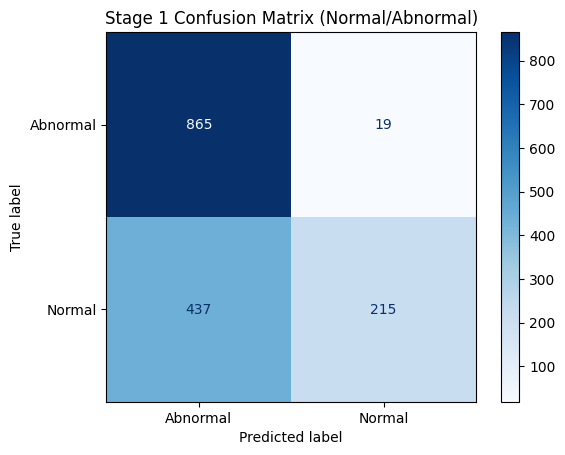


Stage 1 Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.66      0.98      0.79       884
      Normal       0.92      0.33      0.49       652

    accuracy                           0.70      1536
   macro avg       0.79      0.65      0.64      1536
weighted avg       0.77      0.70      0.66      1536


--- Stage 2 모델 최종 평가 ---


c:\Users\jh\.conda\envs\tf-gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step


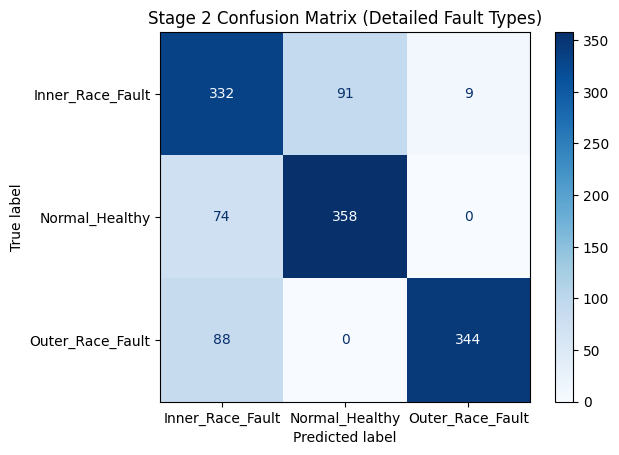


Stage 2 Classification Report:
                  precision    recall  f1-score   support

Inner_Race_Fault       0.67      0.77      0.72       432
  Normal_Healthy       0.80      0.83      0.81       432
Outer_Race_Fault       0.97      0.80      0.88       432

        accuracy                           0.80      1296
       macro avg       0.81      0.80      0.80      1296
    weighted avg       0.81      0.80      0.80      1296


모든 평가지표 계산 및 시각화가 완료되었습니다. 🎉


In [33]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 설정 (Configuration) ---
# 이미지 파라미터 (모델 학습 시 사용했던 것과 동일해야 함)
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 128
# IMAGE_CHANNELS = 1 # 흑백 스펙트로그램 이미지이므로 1 (flow_from_directory에서 color_mode로 지정)
BATCH_SIZE = 32

# 데이터셋 루트 폴더 경로 (테스트 데이터 로드를 위해 필요)
data_root_dir = 'C:/Users/jh/Documents/GitHub/BearingGuardian/Split_Spectrograms_Data'
test_data_dir = os.path.join(data_root_dir, 'test')

print(f"테스트 데이터 경로: {test_data_dir}")
print(f"이미지 크기: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")

# --- 2. 테스트셋 불러오기 (ImageDataGenerator 사용) ---
# 반드시 테스트셋은 동일하게 로드해야 함
# 테스트 데이터는 정규화만 적용 (증강 없음)
test_datagen_stage1 = ImageDataGenerator(rescale=1./255)
test_datagen_stage2 = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 사용하여 물리적으로 분리된 테스트 디렉토리에서 이미지 로드
# Stage 1: 정상/비정상 이진 분류
test_generator_stage1 = test_datagen_stage1.flow_from_directory(
    os.path.join(test_data_dir, 'stage1'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale', # 흑백 스펙트로그램이므로 'grayscale'
    batch_size=BATCH_SIZE,
    class_mode='binary', # 이진 분류
    shuffle=False, # 평가를 위해 순서를 섞지 않음 (중요!)
    seed=42 # 재현성을 위해 random_state(seed) 고정 (중요!)
)

# Stage 2: 세부 고장 유형 다중 분류
test_generator_stage2 = test_datagen_stage2.flow_from_directory(
    os.path.join(test_data_dir, 'stage2'),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='grayscale', # 흑백 스펙트로그램이므로 'grayscale'
    batch_size=BATCH_SIZE,
    class_mode='categorical', # 다중 클래스 분류
    shuffle=False, # 평가를 위해 순서를 섞지 않음 (중요!)
    seed=42 # 재현성을 위해 random_state(seed) 고정 (중요!)
)

print(f"Stage 1 테스트 이미지 수: {test_generator_stage1.samples}, 클래스 수: {test_generator_stage1.num_classes}")
print(f"Stage 2 테스트 이미지 수: {test_generator_stage2.samples}, 클래스 수: {test_generator_stage2.num_classes}")

# --- 3. 저장된 모델 불러오기 ---
# Stage 1 모델 파일 경로 (실제 저장된 파일명과 확장자에 맞게 수정하세요!)
stage1_model_filepath = 'stage1_best_model.h5' # 또는 'stage1_final_model.keras'
# Stage 2 모델 파일 경로 (실제 저장된 파일명과 확장자에 맞게 수정하세요!)
stage2_model_filepath = 'stage2_best_model.h5' # 또는 'stage2_final_model.keras'

try:
    # 모델 불러오기
    loaded_stage1_model = tf.keras.models.load_model(stage1_model_filepath)
    print(f"'{stage1_model_filepath}' 모델을 성공적으로 불러왔습니다.")

    loaded_stage2_model = tf.keras.models.load_model(stage2_model_filepath)
    print(f"'{stage2_model_filepath}' 모델을 성공적으로 불러왔습니다.")

except Exception as e:
    print(f"모델 불러오기 오류: {e}")
    print("저장된 모델 파일 경로와 이름이 올바른지 확인해주세요.")
    print("예: .h5 대신 .keras 확장자로 저장되었을 수 있습니다.")
    exit() # 모델 로드 실패 시 스크립트 종료

# --- 4. 예측 수행 및 평가지표 계산 ---

print("\n--- Stage 1 모델 최종 평가 ---")
# 예측 수행
stage1_predictions = loaded_stage1_model.predict(test_generator_stage1)
# 이진 분류이므로 0.5를 기준으로 클래스 예측
stage1_predicted_classes = (stage1_predictions > 0.5).astype(int)
# 실제 레이블
stage1_true_classes = test_generator_stage1.classes

# 혼동 행렬 계산 및 시각화
cm_stage1 = confusion_matrix(stage1_true_classes, stage1_predicted_classes)
disp_stage1 = ConfusionMatrixDisplay(confusion_matrix=cm_stage1, display_labels=list(test_generator_stage1.class_indices.keys()))
disp_stage1.plot(cmap=plt.cm.Blues)
plt.title('Stage 1 Confusion Matrix (Normal/Abnormal)')
plt.show()

# 분류 보고서 (정밀도, 재현율, F1-점수 등)
report_stage1 = classification_report(stage1_true_classes, stage1_predicted_classes, target_names=list(test_generator_stage1.class_indices.keys()))
print("\nStage 1 Classification Report:")
print(report_stage1)

print("\n--- Stage 2 모델 최종 평가 ---")
# 예측 수행
stage2_predictions = loaded_stage2_model.predict(test_generator_stage2)
# 다중 클래스 분류이므로 가장 높은 확률의 인덱스 선택
stage2_predicted_classes = np.argmax(stage2_predictions, axis=1)
# 실제 레이블
stage2_true_classes = test_generator_stage2.classes

# 혼동 행렬 계산 및 시각화
cm_stage2 = confusion_matrix(stage2_true_classes, stage2_predicted_classes)
disp_stage2 = ConfusionMatrixDisplay(confusion_matrix=cm_stage2, display_labels=list(test_generator_stage2.class_indices.keys()))
disp_stage2.plot(cmap=plt.cm.Blues)
plt.title('Stage 2 Confusion Matrix (Detailed Fault Types)')
plt.show()

# 분류 보고서 (정밀도, 재현율, F1-점수 등)
report_stage2 = classification_report(stage2_true_classes, stage2_predicted_classes, target_names=list(test_generator_stage2.class_indices.keys()))
print("\nStage 2 Classification Report:")
print(report_stage2)

print("\n모든 평가지표 계산 및 시각화가 완료되었습니다. 🎉")
